In [391]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from skimage.segmentation import slic
import os
from skimage.filters import gabor
from skimage import color
from skimage.segmentation import mark_boundaries

In [392]:
image_path = "data/B29.jpg"
filename = os.path.splitext(os.path.basename(image_path))[0]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
K = 2

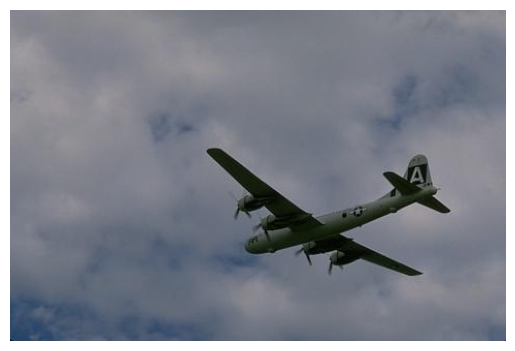

In [393]:
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

In [394]:
centroid_colors = np.array([
    [255, 255, 0],  # Yellow
    [0, 0, 255],    # Blue
    [0, 255, 255],   # Cyan
    [255, 0, 0],    # Red
    [0, 255, 0],    # Green
    [255, 0, 255] # Magenta
])

## Pixel-Level Features

In [395]:
def get_RGB_color_features(image):
    return image.reshape((-1, 3))

In [396]:
def get_RGB_and_spatial_features(image):
    height, width, _ = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    x_normalized = (x - np.min(x)) / (np.max(x) - np.min(x))
    y_normalized = (y - np.min(y)) / (np.max(y) - np.min(y))

    return np.column_stack((image.reshape((-1, 3)), x_normalized.flatten(), y_normalized.flatten()))

In [397]:
rgb_color_features = get_RGB_color_features(image)
rgb_and_spatial_features = get_RGB_and_spatial_features(image)

## Superpixel-Level Features

In [398]:
def get_segments(image, num_superpixels, sigma=1):
    return slic(image, n_segments=num_superpixels, compactness=10, sigma=1)

In [399]:
num_superpixels = 60
segments = get_segments(image, num_superpixels)

C:\Users\malko\AppData\Local\Temp\ipykernel_13152\2260713570.py:2: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return slic(image, n_segments=num_superpixels, compactness=10, sigma=1)


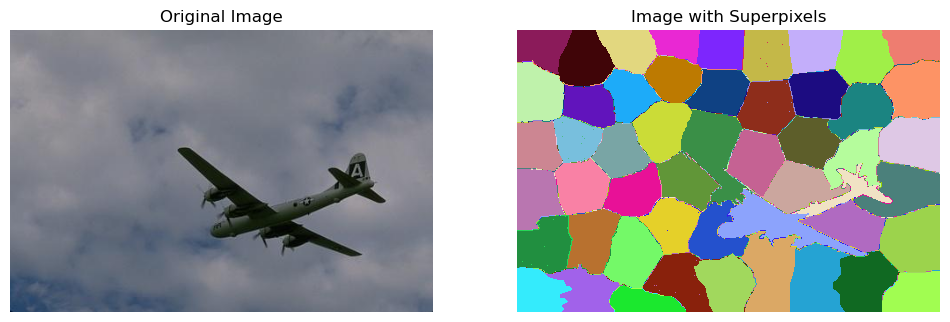

In [400]:
cmap = colors.ListedColormap(np.random.rand(num_superpixels, 3))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(segments, cmap=cmap)
ax[1].set_title('Image with Superpixels')
ax[1].axis('off')

plt.show()

#### (a) Mean of RGB color values

In [401]:
def calculate_mean_color_values(image, segments):
    num_segments = np.max(segments)
    mean_colors = np.zeros((num_segments, 3), dtype=np.float64)

    for i in range(0, num_segments):
        indices = np.where(segments-1 == i)
        superpixel_colors = image[indices]
        mean_rgb = np.mean(superpixel_colors, axis=0)
        mean_colors[i] = mean_rgb

    return mean_colors

In [402]:
mean_colors = calculate_mean_color_values(image, segments)

#### (b) RGB color histogram

In [403]:
def calculate_rgb_histograms(image, segments, bins=256):
    num_segments = np.max(segments) + 1
    histograms = np.zeros((num_segments, bins * 3), dtype=np.float64)

    for segment_id in range(num_segments):
        mask = np.where(segments == segment_id, True, False)
        pixels_in_superpixel = image[mask]

        if pixels_in_superpixel.size > 0:
            for channel in range(3):
                channel_values = pixels_in_superpixel[:, channel]
                hist, _ = np.histogram(channel_values, bins=bins, range=(0, 256))
                normalized_hist = hist / np.sum(hist)
                start_idx, end_idx = channel * bins, (channel + 1) * bins
                histograms[segment_id, start_idx:end_idx] = normalized_hist
        else:
            histograms[segment_id, :] = 0.0

    return histograms

In [404]:
rgb_histograms = calculate_rgb_histograms(image, segments)

### K MEANS CLUSTERING

In [405]:
# I tried to implement the k means clustering algorithm in the text book
def k_means(X, K, max_iters=100):
    # Step 1: Randomly initialize cluster centers
    centroids = X[np.random.choice(range(len(X)), K, replace=False)]

    for _ in range(max_iters):
        # Step 2: Assign points to clusters
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)

        # Step 3: Update cluster centers
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])

        # Step 4: Check for convergence
        if np.all(new_centroids == centroids):
            break

        centroids = new_centroids

    return centroids, labels

## EXPERIMENTS

In [406]:
centroids, labels = k_means(rgb_color_features, K)

In [407]:
new_centroids = centroids.copy()[:,:3]
new_centroids = centroid_colors[:K]
reconstruced_image = new_centroids[labels].reshape(image.shape).astype(np.uint16)

In [408]:
reshaped_labels = labels.reshape(image.shape[:2])
marked_image = mark_boundaries(image, reshaped_labels, color=(0, 1, 0), mode='thick')

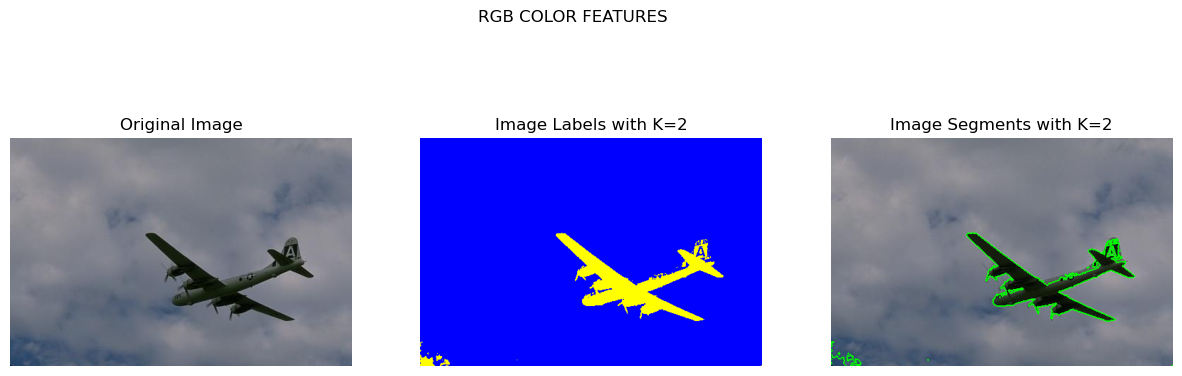

In [409]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstruced_image)
plt.title(f'Image Labels with K={K}')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(marked_image)
plt.title(f'Image Segments with K={K}')
plt.axis('off')

plt.suptitle('RGB COLOR FEATURES')
output_filename = f"{filename}/RGB_{filename}_K{K}"
plt.savefig(output_filename)
plt.show()

In [410]:
centroids, labels = k_means(rgb_and_spatial_features, K)

In [411]:
new_centroids = centroids.copy()
new_centroids = centroid_colors[:K]
reconstruced_image = new_centroids[labels].reshape(image.shape).astype(np.uint16)

In [412]:
reshaped_labels = labels.reshape(image.shape[:2])
marked_image = mark_boundaries(image, reshaped_labels, color=(0, 1, 0), mode='thick')

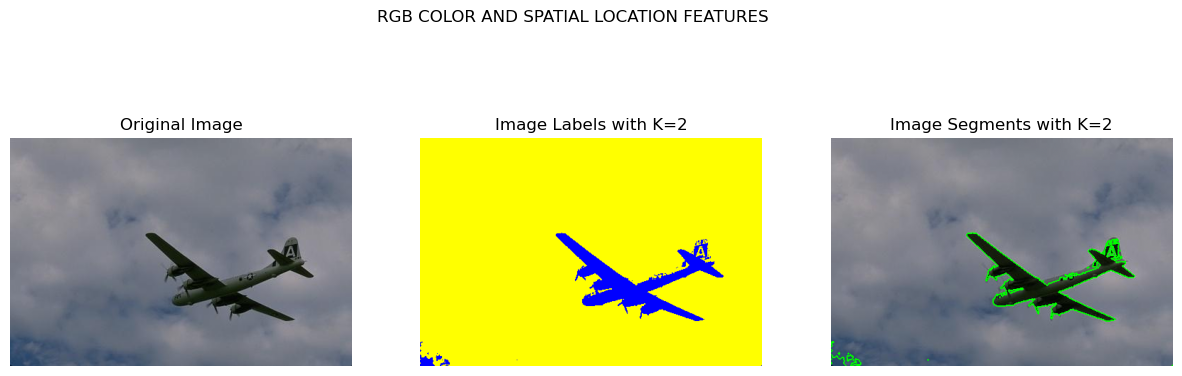

In [413]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstruced_image)
plt.title(f'Image Labels with K={K}')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(marked_image)
plt.title(f'Image Segments with K={K}')
plt.axis('off')

plt.suptitle('RGB COLOR AND SPATIAL LOCATION FEATURES')
output_filename = f"{filename}/RGB_SPATIAL_{filename}_K{K}"
plt.savefig(output_filename)
plt.show()

In [414]:
centroids, labels = k_means(mean_colors, K)

In [415]:
new_centroids = centroids.copy()
new_centroids = centroid_colors[:K]
reconstructed_image = np.zeros_like(image, dtype=np.uint8)

#assign colors to the corresponding segments in the reconstructed image
for i in range(image.shape[0]):
  for j in range(image.shape[1]):
    superpixelnum = segments[i,j]
    label = labels[superpixelnum-1]
    reconstructed_image[i,j] = new_centroids[label]


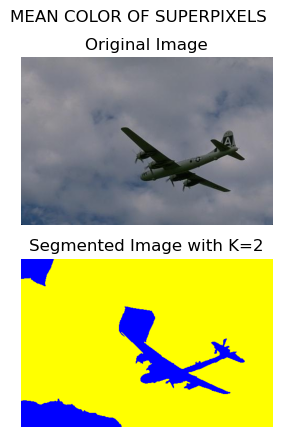

In [416]:
plt.subplot(2, 1, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(reconstructed_image)
plt.title(f'Segmented Image with K={K}')
plt.axis('off')

plt.suptitle('MEAN COLOR OF SUPERPIXELS')
output_filename = f"{filename}/MEAN_COLOR_{filename}_K{K}"
plt.savefig(output_filename)
plt.show()

In [417]:
centroids, labels = k_means(rgb_histograms, K)

In [418]:
new_centroids = centroids.copy()
new_centroids = centroid_colors[:K]
reconstructed_image = np.zeros_like(image, dtype=np.uint8)

#assign colors to the corresponding segments in the reconstructed image
for i in range(image.shape[0]):
  for j in range(image.shape[1]):
    superpixelnum = segments[i,j]
    label = labels[superpixelnum-1]
    reconstructed_image[i,j] = new_centroids[label]

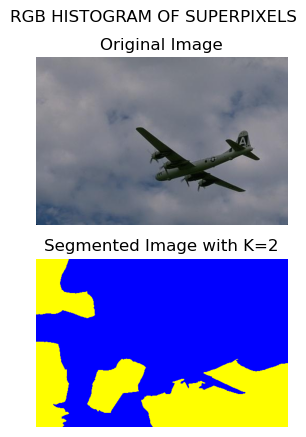

In [419]:
plt.subplot(2, 1, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(reconstructed_image)
plt.title(f'Segmented Image with K={K}')
plt.axis('off')

plt.suptitle('RGB HISTOGRAM OF SUPERPIXELS')
output_filename = f"{filename}/RGB_HISTOGRAM_{filename}_K{K}"
plt.savefig(output_filename)
plt.show()

In [420]:
def generate_gabors(image, sigma, num_orientations):
    filters = []
    for theta in range(num_orientations):
        theta = theta / num_orientations * np.pi
        kernel = np.real(gabor(image, frequency=0.1, theta=theta, sigma_x=sigma, sigma_y=sigma)[0])
        filters.append(kernel)
    return filters

In [421]:
num_orientations = 8
sigma_value = 1.5
gray_image = color.rgb2gray(image)
filterbank = generate_gabors(gray_image, sigma_value, num_orientations)
response_maps = [cv2.filter2D(gray_image, cv2.CV_64F, kernel) for kernel in filterbank]

superpixel_means = np.zeros((len(np.unique(segments)), len(filterbank)))
for segment_id, label in enumerate(np.unique(segments)):
    mask = (segments == label)
    superpixel_means[segment_id, :] = [response_map[mask].mean() for response_map in response_maps]

In [422]:
centroids, labels = k_means(superpixel_means, K)

In [423]:
new_centroids = centroids.copy()
new_centroids = centroid_colors[:K]
reconstructed_image = np.zeros_like(image, dtype=np.uint8)

#assign colors to the corresponding segments in the reconstructed image
for i in range(image.shape[0]):
  for j in range(image.shape[1]):
    superpixelnum = segments[i,j]
    label = labels[superpixelnum-1]
    reconstructed_image[i,j] = new_centroids[label]

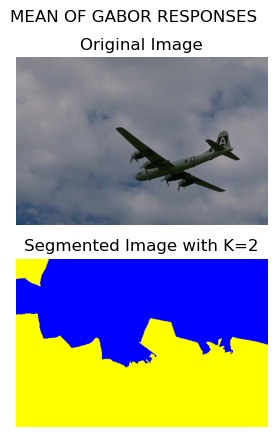

In [424]:
plt.subplot(2, 1, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(reconstructed_image)
plt.title(f'Segmented Image with K={K}')
plt.axis('off')

plt.suptitle('MEAN OF GABOR RESPONSES')
output_filename = f"{filename}/MEAN_OF_GABOR_RESPONSES_{filename}_K{K}"
plt.savefig(output_filename)
plt.show()